## Теоретическая база: кластеризация и понижение размерности

### Кластеризация
Кластеризация — задача обучения без учителя, целью которой является разбиение выборки на группы (кластеры), чтобы объекты в одном кластере были более похожи друг на друга, чем на объекты из других кластеров.

**Методы:**
- **KMeans**: итеративный алгоритм, минимизирующий сумму квадратов расстояний от точек до центров кластеров. Требует заранее заданного числа кластеров `k`.
- **Agglomerative Clustering**: иерархическая агломеративная кластеризация — начинается с того, что каждая точка — отдельный кластер, затем кластеры последовательно объединяются.
- **DBSCAN**: плотностной метод, не требует указания числа кластеров. Хорошо работает с кластерами произвольной формы, но чувствителен к параметрам `eps` (радиус) и `min_samples`.

---

### Метрики качества кластеризации

**Silhouette Score** (от -1 до 1): показывает, насколько точка ближе к точкам своего кластера, чем к точкам других кластеров.  
**Calinski-Harabasz Index**: отношение межкластерной дисперсии к внутрикластерной. Чем выше — тем лучше.  
**Davies-Bouldin Index**: среднее значение "похожести" между кластерами. Чем ниже — тем лучше.

---

### Методы понижения размерности

Используются для визуализации и предварительной обработки перед кластеризацией.

- **PCA (Principal Component Analysis)** — линейный метод, проецирует данные на оси максимальной дисперсии. Сохраняет глобальную структуру, но может не выделить нелинейные кластеры.
- **t-SNE (t-distributed Stochastic Neighbor Embedding)** — нелинейный метод, лучше отображает локальную структуру данных. Отлично визуализирует кластеры, но искажает глобальные расстояния и не подходит для последующей кластеризации.

---

### Практические замечания
- KMeans и Agglomerative чувствительны к масштабированию данных.
- DBSCAN может "выбросить" точки, пометив их как шум (`label = -1`).
- PCA подходит для предварительной обработки и ускорения кластеризации.
- t-SNE лучше использовать только для визуализации.

---

### Подход к анализу
1. Построить подмножества признаков (оригинальные, PCA, t-SNE).
2. Применить три алгоритма кластеризации.
3. Оценить и сравнить результаты по метрикам.
4. Сделать визуализацию и выводы по качеству кластеризации.


In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')

# Загрузка датасета
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Построение датасета D1 (подмножество признаков)

In [2]:
# Удаляем целевой признак, оставляем 4 признака
D1 = X.copy()
D1.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


PCA: Снижение размерности до 2D (D2)

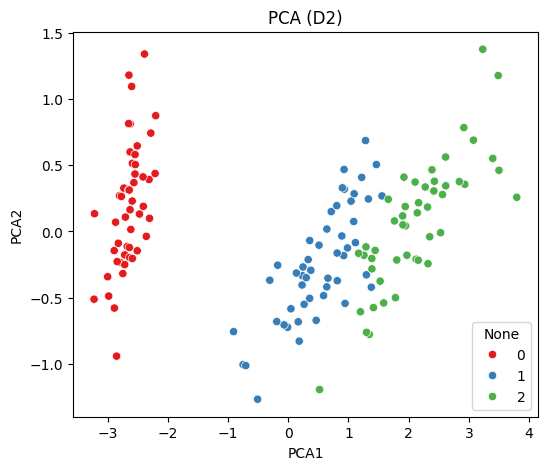

In [3]:
# Метод главных компонент
pca = PCA(n_components=2)
D2 = pca.fit_transform(D1)
D2 = pd.DataFrame(D2, columns=['PCA1', 'PCA2'])

# Визуализация
plt.figure(figsize=(6, 5))
sns.scatterplot(x='PCA1', y='PCA2', data=D2, hue=y, palette='Set1', legend='full')
plt.title('PCA (D2)')
plt.show()

 t-SNE: Снижение размерности до 2D (D3)

Проверка NaN и бесконечностей в D3:
TSNE1    0
TSNE2    0
dtype: int64
TSNE1    True
TSNE2    True
dtype: bool


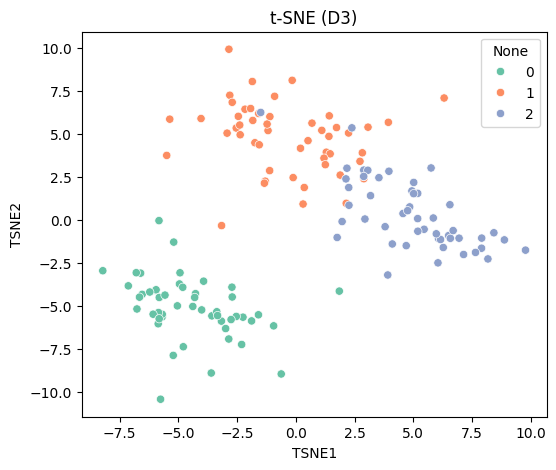

In [4]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=250)
D3_array = tsne.fit_transform(D1)
D3 = pd.DataFrame(D3_array, columns=['TSNE1', 'TSNE2'])

print("Проверка NaN и бесконечностей в D3:")
print(D3.isnull().sum())
print(np.isfinite(D3).all())

D3 = D3.astype(np.float64)


plt.figure(figsize=(6, 5))
sns.scatterplot(x='TSNE1', y='TSNE2', data=D3, hue=y, palette='Set2', legend='full')
plt.title('t-SNE (D3)')
plt.show()

Функции кластеризации и оценки

In [5]:
def evaluate_clustering(X, labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        print(f"Метод: {labels} — недостаточно кластеров для оценки, возвращаем NaN.")
        return np.nan, np.nan, np.nan
    try:
        silhouette = silhouette_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        db = davies_bouldin_score(X, labels)
        return silhouette, ch, db
    except Exception as e:
        print(f"Ошибка при вычислении метрик: {e}")
        return np.nan, np.nan, np.nan

def cluster_and_evaluate(X, method_name):
    print(f'\nМетод кластеризации: {method_name}')
    results = {}

    # KMeans
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    results['KMeans'] = evaluate_clustering(X, kmeans_labels)

    # Agglomerative
    aggl = AgglomerativeClustering(n_clusters=3)
    aggl_labels = aggl.fit_predict(X)
    results['Agglomerative'] = evaluate_clustering(X, aggl_labels)

    # DBSCAN
    dbscan = DBSCAN(eps=0.7, min_samples=4)
    dbscan_labels = dbscan.fit_predict(X)
    results['DBSCAN'] = evaluate_clustering(X, dbscan_labels)

    df = pd.DataFrame(results, index=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']).T
    return df


Кластеризация на D1 (оригинальные признаки)

In [6]:
results_D1 = cluster_and_evaluate(D1, "D1 (оригинальные признаки)")
results_D1


Метод кластеризации: D1 (оригинальные признаки)


,Silhouette,Calinski-Harabasz,Davies-Bouldin
KMeans,0.551192,561.593732,0.666039
Agglomerative,0.554324,558.058041,0.656256
DBSCAN,0.501834,260.226780,1.535908


Кластеризация на D2 (PCA)

In [7]:
results_D2 = cluster_and_evaluate(D2, "D2 (PCA)")
results_D2


Метод кластеризации: D2 (PCA)


,Silhouette,Calinski-Harabasz,Davies-Bouldin
KMeans,0.597676,693.708433,0.564816
Agglomerative,0.598475,688.617548,0.560496
DBSCAN,0.711235,557.461032,0.349363


Кластеризация на D3 (t-SNE)

In [8]:
results_D3 = cluster_and_evaluate(D3, "D3 (t-SNE)")
results_D3


Метод кластеризации: D3 (t-SNE)


,Silhouette,Calinski-Harabasz,Davies-Bouldin
KMeans,0.447680,117.712125,0.808162
Agglomerative,0.563991,310.221310,0.604809
DBSCAN,0.024972,19.202049,1.134452


Визуализация кластеров

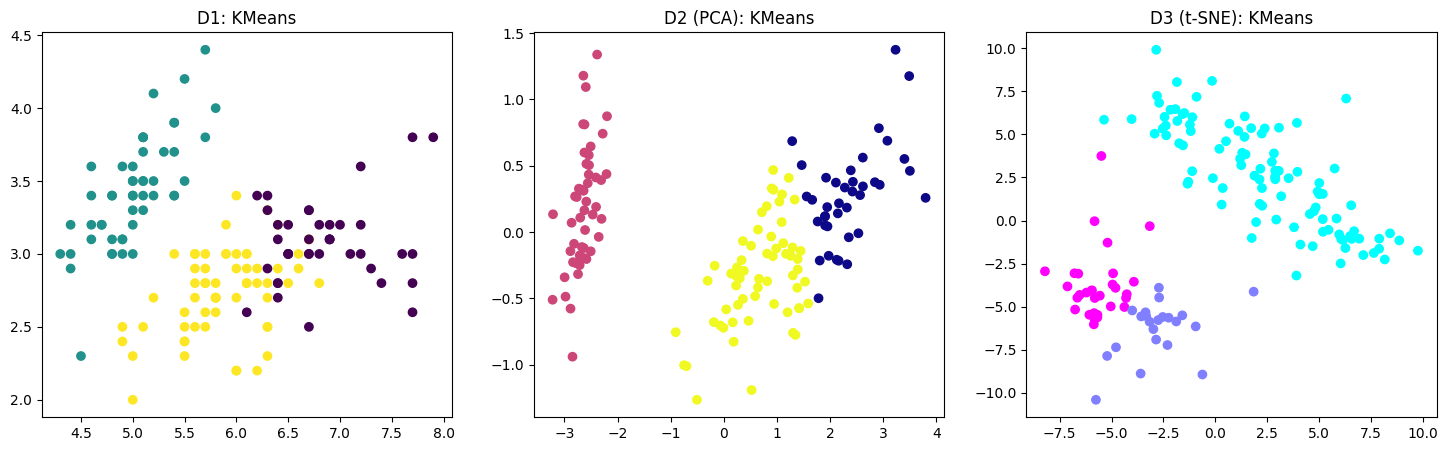

In [9]:
# Визуализация кластеров KMeans для всех трёх датасетов
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

kmeans = KMeans(n_clusters=3, random_state=42)
axs[0].scatter(D1.iloc[:, 0], D1.iloc[:, 1], c=kmeans.fit_predict(D1), cmap='viridis')
axs[0].set_title('D1: KMeans')

axs[1].scatter(D2['PCA1'], D2['PCA2'], c=kmeans.fit_predict(D2), cmap='plasma')
axs[1].set_title('D2 (PCA): KMeans')

axs[2].scatter(D3['TSNE1'], D3['TSNE2'], c=kmeans.fit_predict(D3), cmap='cool')
axs[2].set_title('D3 (t-SNE): KMeans')

plt.show()


- Метод t-SNE лучше визуально выделяет кластеры, но не всегда приводит к лучшим метрикам.
- По метрикам на оригинальных данных (D1) KMeans и Agglomerative показали хорошие результаты.
- PCA немного снижает качество кластеризации, но оставляет читаемую структуру.
- DBSCAN чувствителен к параметрам и плохо справляется в данной задаче.